# CIFAR10을 CNN으로 학습하기. 여러 학습 방법으로 비교

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=1

# 1. CIFAR10 train, test dataset 가져오기

MNIST: 11MB

In [4]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(),
                         target_transform=None, download=True)
#(2) Data augmentation
# cifar_train=dset.CIFAR10("CIFAR10/",train=True,
#                          transform=transforms.Compose([
#                              transforms.Scale(36),
#                              transforms.CenterCrop(32),
#                              transforms.RandomHorizontalFlip(),
#                              transforms.Lambda(lambda x: x.rotate(90)),
#                              transforms.ToTensor()
#                          ]))

#(4) Data Normalization
# cifar_train=dset.CIFAR10("CIFAR10/",train=True,
#                          transform=transforms.Compose([
#                              transforms.Tensor(),
#                              transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
#                          ])
#                          , target_trasnform=None, download=False)

# cifar_test=dset.CIFAR10("CIFAR10/",train=False,
#                          transform=transforms.Compose([
#                              transforms.Tensor(),
#                              transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
#                          ])
#                          , target_trasnform=None, download=False)


cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(),
                         target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태

cifar_train 길이: 50000
cifar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label: 9


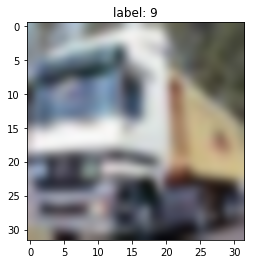

In [5]:
print "cifar_train 길이:", len(cifar_train)
print "cifar_test 길이:", len(cifar_test)

#데이터 하나 형태
image, label = cifar_train.__getitem__(1) #1번째 데이터
print "image data 형태:", image.size()
print "label:", label

#그리기
img = image.numpy() #image 타입을 numpy로 변환 (3,32,32) rgb, W, H

#(3,32,32)->(32,32,3)
r,g,b = img[0,:,:],img[1,:,:],img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0],img2[:,:,1],img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [6]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size만큼
        img = Variable(imgs,volatile=True) #x
        #label = Variable(labels) #y
        label = Variable(labels)
        
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [9]:
# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True,num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4. 모델 선언 ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            #nn.TatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            #nn.TatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            #nn.TatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            #nn.Dropout2d(0.2),
            #nn.BatchNorm2d(100),
            nn.Linear(100,10)
        )
        
        #(3) weight initializaion
#         for n in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal(m.weight.data) #REUL 일 때
#                 m.bias.data.fill_(0)
#             if isinstance(m, nn.Linear):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
    
    def forward(self,x):
        out=self.layer(x)
        out=out.view(batch_size,-1)
        out=self.fc_layer(out)
        
        return out
model=CNN()

In [10]:
# === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) #(6) Adam optimizer

#scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2) #(7) learning rate decay

# === 6. 학습 ===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

OSError: [Errno 12] Cannot allocate memory

## (0) Naive Test

In [8]:
ComputeAccr(test_loader, model)

NameError: name 'model' is not defined

## (1) drop out

In [18]:
ComputeAccr(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 10.4099998474


## (2) Data augmentation

In [21]:
ComputeAccr(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 10.4600000381


## (3) Wieght initialization

In [26]:
ComputeAccr(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 9.93999958038


## (4) Data Normalization

In [32]:
ComputeAccr(test_loader, model)


/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 10.2399997711


## (5) Batch normalization

In [ ]:
ComputeAccr(test_loader, model)

## (6) Adam optimizer

In [ ]:
ComputeAccr(test_loader, model)

## (7) learning rate decay

In [ ]:
ComputeAccr(test_loader, model)